Imports

In [9]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from abm1559.utils import (
    constants, 
    set_constants,
)
from abm1559.txpool import TxPool
from abm1559.users import User1559
from abm1559.userpool import UserPool
from abm1559.chain import (
    Chain,
    Block1559,
)
from abm1559.simulator import (
    spawn_poisson_demand,
    update_basefee,
)
import pandas as pd
import numpy as np
import math
from ast import literal_eval
import matplotlib.pyplot as plt

In [10]:
def scale_demand(scenario, divisor):
    scale_demand = []
    for x in scenario:
        scale_demand.append(math.trunc(x/divisor))
    return scale_demand

Set data

In [11]:
FILE_NAME = 'test'
set_constants(initial=1 * (10 ** 9), target_gas=1500000, max_gas=3000000, included=100)

Main simulation function

In [12]:
def simulate(demand_scenario, UserClass):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()

    for t in range(len(demand_scenario)):
        if t % 100 == 0: print(t)

        # `env` is the "environment" of the simulation
        env = {
            "basefee": basefee,
            "current_block": t,
        }

        # We return a demand drawn from a Poisson distribution.
        # The parameter is given by `demand_scenario[t]`, and can vary
        # over time.
        users = spawn_poisson_demand(t, demand_scenario[t], UserClass)

        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length(),
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

In [13]:
f = open('../results/demand-scenario01.txt', "r")
file_content = f.read()
f.close()
demand_scenario = literal_eval(file_content)
# demand_scenario_scaled = scale_demand(demand_scenario, 10)

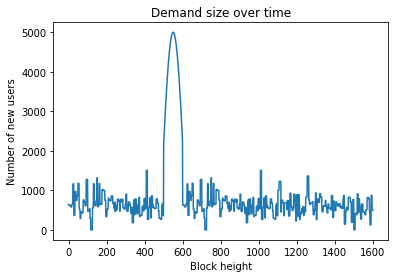

In [14]:
sin_len = 0.5
points = 140
y_axis = 5000
length = np.pi * sin_len * 2
fluct = y_axis * np.sin(np.arange(0, length, length / points))

demand_usual = demand_scenario[2000:3001]
demand_usual = scale_demand(demand_usual, 5)

demand_fluct = demand_usual[:500]
end_value = points-20
demand_fluct.extend(fluct[20:end_value])
demand_fluct.extend(demand_usual)

# Plot demand
f, ax = plt.subplots()
plt.title('Demand size over time', color='black')
plt.plot(demand_fluct)
ax.set_xlabel("Block height")
ax.set_ylabel("Number of new users")
plt.show()

resfile = open("../results/demand-fluct.txt", "w")
resfile.write(str(demand_fluct))
resfile.close()

Simulation run

In [15]:
(df, user_pool, chain) = simulate(demand_fluct, User1559)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


Data export

In [16]:
filepath = '../results/' + FILE_NAME + '.pkl'
df.to_pickle(filepath)